### Esercitazione 12 - CCI (Commodity Channel Index)
#### Argomenti

* indicatore CCI
* implementazione di una strategia semplice per sfruttare il CCI

Il CCI è un indicatore che misura la differenza tra il prezzo attuale e il prezzo medio
storico in un determinato periodo di tempo.
Quando il valore del CCI rivela letture estremamente positive, si considera che il prezzo attuale
sia ben al di sopra della media storica. Allo stesso modo, quando il valore di CCI rivela letture
estremamente negative, allora si considera che il prezzo corrente sia inferiore alla media storica.

A giudicare dal suo nome, si potrebbe pensare che il CCI sia usato per scambiare solo materie prime,
ma non è così: può essere utilizzato per fare trading in qualsiasi forma di mercato, sia esso azionario
o forex.

L'impostazione più generale di CCI è 20 come numero di periodi da considerare.
La formula per calcolare CCI con 20 come numero di periodi è rappresentata di seguito:

CCI = (TP - SMA 20 di TP) / (0.15 * DEV.MEDIA)

dove
TP = Tipical Price, calcolato con la formula: (HIGH + LOW + CLOSE) / 3    
SMA = Simple Moving Average - media mobile calcolata sui valori di TP    
DEV.MEDIA = deviazione standard dalla media calcolata su TP    
    
Non ha limiti ai valori che può assumere, come ad esempio accade per l'RSI; per determinare i livelli di
CCI corrispondenti alle aree di ipervenduto e ipercomprato si devono considerare i picchi massimi e
minimi di CCI relativi allo strumento finanziario in analisi (questa strategia per impostare i
limiti del CCI prende il nome di strategia di inversione, si attendono le inversioni di mercato per
tracciare i livelli massimi e minimi -relativi- del CCI).

In [1]:
import MetaTrader5 as mt5
import pandas as pd
import talib
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import numpy as np

In [2]:
connected = mt5.initialize(login=5798528, server="ActivTrades-Server", password='QFPHrdgg')

if connected:
    candles = pd.DataFrame(mt5.copy_rates_from_pos('META.US-d', mt5.TIMEFRAME_D1, 0, 1000))
    mt5.shutdown()
else:
    print('MT5 account error.')

candles['time'] = pd.to_datetime(candles['time'], unit='s')
candles.set_index('time', inplace=True)

In [3]:
timeperiod = 90
candles['cci'] = talib.CCI(candles['high'], candles['low'], candles['close'], timeperiod=timeperiod)
candles['cci_1'] = candles['cci'].shift(1)  # CCI della candela precedente

candles = candles[timeperiod:]
candles.head()

,open,high,low,close,tick_volume,spread,real_volume,cci,cci_1
time,,,,,,,,,
2019-03-21,164.70,166.37,163.75,166.06,21139,10,0,81.654883,77.713805
2019-03-22,165.53,167.40,164.07,164.58,30726,10,0,79.219555,81.654883
2019-03-25,163.01,166.53,162.00,166.38,30299,10,0,75.171989,79.219555
2019-03-26,167.20,169.43,166.34,167.73,23922,10,0,87.816001,75.171989
2019-03-27,167.78,168.91,164.79,165.82,24006,10,0,78.796969,87.816001


In [4]:
# recupero massimi e minimi relativi

min = candles.iloc[argrelextrema(candles.cci.values, np.less_equal, order=5)[0]]['cci'].values
max = candles.iloc[argrelextrema(candles.cci.values, np.greater_equal, order=5)[0]]['cci'].values

max_mean = np.mean(max)
min_mean = np.mean(min)

candles['cci_status'] = 0
candles['cci_1_status'] = 0

candles.loc[candles['cci'] > max_mean, 'cci_status'] = 1
candles.loc[candles['cci'] < min_mean, 'cci_status'] = -1
candles.loc[candles['cci_1'] > max_mean, 'cci_1_status'] = 1
candles.loc[candles['cci_1'] < min_mean, 'cci_1_status'] = -1

candles.head()

,open,high,low,close,tick_volume,spread,real_volume,cci,cci_1,cci_status,cci_1_status
time,,,,,,,,,,,
2019-03-21,164.70,166.37,163.75,166.06,21139,10,0,81.654883,77.713805,1,1
2019-03-22,165.53,167.40,164.07,164.58,30726,10,0,79.219555,81.654883,1,1
2019-03-25,163.01,166.53,162.00,166.38,30299,10,0,75.171989,79.219555,1,1
2019-03-26,167.20,169.43,166.34,167.73,23922,10,0,87.816001,75.171989,1,1
2019-03-27,167.78,168.91,164.79,165.82,24006,10,0,78.796969,87.816001,1,1


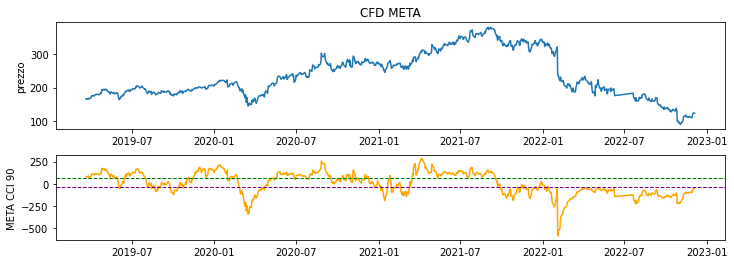

In [5]:
# visualizzazione andamento prezzi e CCI

plt.figure(figsize=(12, 4))

ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 5, colspan = 1)
ax1.plot(candles['close'])
ax1.set_title('CFD META')
ax1.set_ylabel('prezzo')

ax2 = plt.subplot2grid((10,1), (6,0), rowspan = 4, colspan = 1)
ax2.plot(candles['cci'], color = 'orange')
ax2.set_ylabel('META CCI ' + str(timeperiod))
ax2.axhline(max_mean, linestyle = '--', linewidth = 1, color = 'green')
ax2.axhline(min_mean, linestyle = '--', linewidth = 1, color = 'purple')

plt.show()

In [6]:
# implementazione di una strategia che sfrutti i momenti di
# ipervenduto e ipercomprato evidenziati dall'indicatore CCI

operazioni = []

operazione_attuale = candles.iloc[0].cci_status
i = 0
while operazione_attuale != 0 and i < len(candles):
    c = candles.iloc[i]
    operazione_attuale = c.cci_status
    i += 1

while i < len(candles):
    c = candles.iloc[i]
    ts = c.name
    if c.cci_status != c.cci_1_status:
        if operazione_attuale == 0:
            operazione_attuale = c.cci_status
            operazioni.append([ts, np.nan, operazione_attuale, c.close, np.nan])
        else:
            operazioni[-1][1] = ts
            operazioni[-1][4] = c.close
            operazione_attuale = 0
    i += 1

if np.isnan(operazioni[-1][-1]):
    operazioni[-1][1] = c.name
    operazioni[-1][4] = c.close

performance = 0.
for op in operazioni:
    performance += (op[4] - op[3]) * op[2]

print(len(operazioni), 'operazioni')
print('ritorno:', performance)

35 operazioni
ritorno: 137.44999999999996


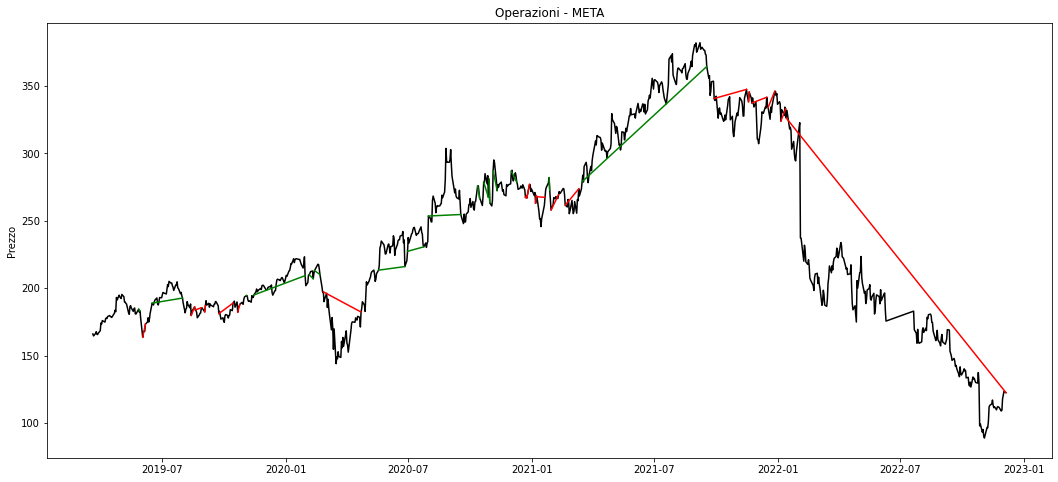

In [7]:
plt.figure(figsize=(18, 8))
plt.title('Operazioni - META')
plt.plot(candles['close'], color='black')
plt.ylabel('Prezzo')

for op in operazioni:
    if op[2] == 1:
        plt.plot([op[0], op[1]], [op[3], op[4]], color='green')
    else:
        plt.plot([op[0], op[1]], [op[3], op[4]], color='red')

plt.show()